In [236]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [237]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [238]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2'
)

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [239]:
#set list of tickers and timeframe
list_of_tickers = ["SPY", "AGG"]
timeframe = '1D'

# end_date = datetime.now()
# start_date = end_date + timedelta(-365)

#set start and end dates
start_date = pd.Timestamp('2014-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# call api to get stock data
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# remove timestamp from the index
df.index = df.index.date

# drop non-essential columns
df.drop(columns=[
    'open',
    'high',
    'low',
    'volume',
],\
        level=1, inplace=True)

# rename remaining columns to represent stock
df.columns = ['AGG_close', 'SPY_close']

df.head()

,AGG_close,SPY_close
2014-01-02,106.500,182.95
2014-01-03,106.535,182.80
2014-01-06,106.660,182.40
2014-01-07,106.748,183.44
2014-01-08,106.400,183.53


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [240]:
# Calculate the daily roi for the stocks
returns = df.pct_change(1)
returns.dropna(inplace=True)
returns.head()

,AGG_close,SPY_close
2014-01-03,0.000329,-0.000820
2014-01-06,0.001173,-0.002188
2014-01-07,0.000825,0.005702
2014-01-08,-0.003260,0.000491
2014-01-09,0.001410,0.000545


In [241]:
# calculate average daily returns
avg_daily_return_spy = returns['SPY_close'].mean()
avg_daily_return_agg = returns['AGG_close'].mean()

In [242]:
df.tail()

,AGG_close,SPY_close
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10
2019-12-31,112.370,321.92


In [243]:
# Calculate volatility
std_dev_daily_return_spy = returns['SPY_close'].std()
std_dev_daily_return_agg = returns['AGG_close'].std()

In [244]:
# Save the last day's closing price
agg_last_close = df['AGG_close'][-1]
spy_last_close = df['SPY_close'][-1]

In [245]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [246]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices lists
    simulated_spy_prices = [spy_last_close]
    simulated_agg_prices = [agg_last_close]
    
    # Simulate the returns for 252 * 30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] *\
        (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] *\
        (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["SPY_prices"] = pd.Series(simulated_spy_prices)
    monte_carlo["AGG_prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002614,0.995267,0.992746,0.999246,1.005309,1.006994,1.009547,0.995612,1.001582,0.998922,...,1.001888,0.995390,1.007237,0.999642,0.997361,1.002862,0.995715,0.993180,1.002961,0.997029
2,1.007310,0.998950,0.991626,0.998089,1.008474,0.997235,1.003525,0.984382,1.000466,1.007481,...,1.003722,1.002722,1.010160,1.001011,0.998537,0.999495,0.994894,0.993400,1.002630,1.000596
3,1.006215,0.998729,0.995020,0.991734,1.007546,1.000294,1.007221,0.977972,0.999961,1.015606,...,1.003461,1.005405,1.014749,1.002206,0.991463,0.997869,0.998405,0.999103,1.005827,0.999011
4,1.014973,1.001437,0.990931,0.997442,1.008727,0.994737,1.005561,0.974931,1.007897,1.004644,...,1.005212,1.003195,1.012966,1.007440,0.997597,0.994476,0.992306,0.999509,1.010335,1.002384


In [247]:
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,7.636832,6.099411,8.434105,9.130780,8.248746,6.379554,7.937073,12.666058,8.498269,9.251154,...,2.410906,8.972404,5.113626,8.303477,10.225613,11.454870,3.101880,7.187655,13.750445,3.266710
7557,7.623412,6.120936,8.453796,9.120923,8.183693,6.373026,7.892227,12.738854,8.448093,9.236379,...,2.389362,8.965183,5.102015,8.331130,10.218084,11.524029,3.131611,7.187145,13.882440,3.246245
7558,7.586313,6.120977,8.529128,9.124187,8.206061,6.379297,7.909328,12.753497,8.504901,9.199811,...,2.386716,9.010597,5.103256,8.360179,10.275812,11.481705,3.127973,7.136982,13.973019,3.228950
7559,7.572150,6.161310,8.556552,9.130943,8.198277,6.410155,7.906605,12.717035,8.515681,9.161964,...,2.401308,9.050003,5.058443,8.296759,10.290846,11.440254,3.161189,7.127447,14.020216,3.228039
7560,7.562035,6.183215,8.618950,9.134379,8.218649,6.422740,7.896345,12.652244,8.504664,9.157385,...,2.403323,9.096263,5.033691,8.367429,10.297834,11.445747,3.147187,7.070699,13.909786,3.232794


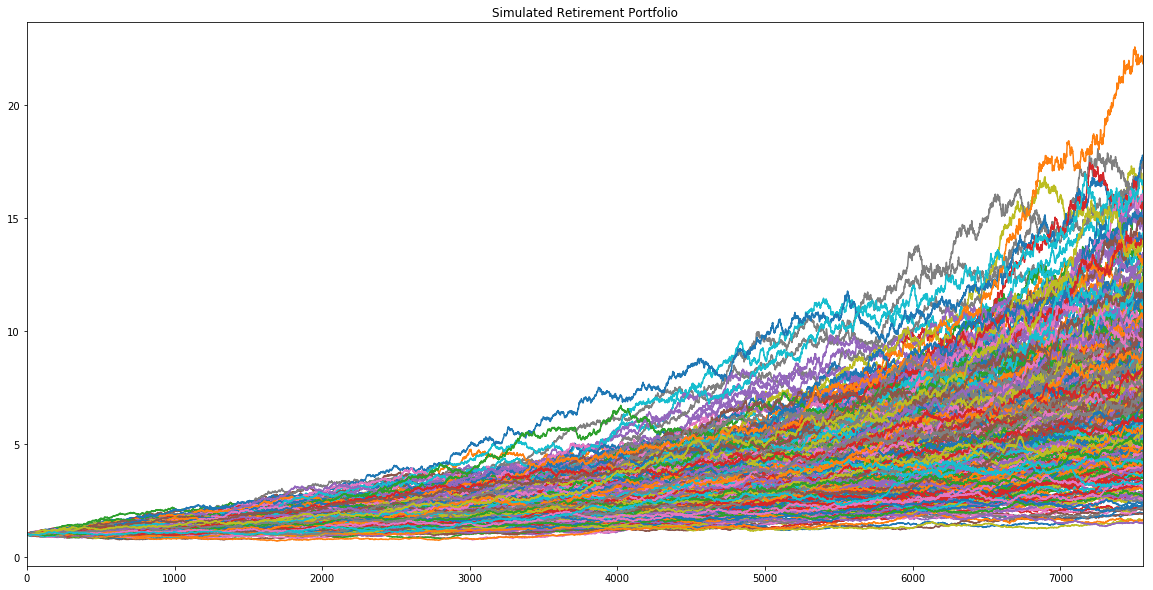

In [248]:
# Visualize the Simulation
plot_title = "Simulated Retirement Portfolio"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(20,10))

In [249]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    7.562035
1    6.183215
2    8.618950
3    9.134379
4    8.218649
Name: 7560, dtype: float64

In [250]:
# Display the 90% confidence interval for the ending returns
ending_cumulative_returns.value_counts(bins=50) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     3.032689
0.95    12.943074
Name: 7560, dtype: float64

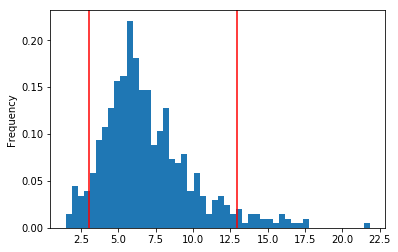

In [251]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [252]:
# desciption of data
ending_cumulative_returns.describe()

count    500.000000
mean       6.976769
std        3.024069
min        1.476814
25%        4.980843
50%        6.330721
75%        8.338827
max       21.851574
Name: 7560, dtype: float64

In [259]:
# calculate returns for percentiles
tenth_percentile = ending_cumulative_returns.quantile(q=0.1)
fiftieth_percentile = ending_cumulative_returns.quantile(q=0.5)
ninetieth_percentile = ending_cumulative_returns.quantile(q=0.9)

# print percentiles
print(f'10th percentile: {tenth_percentile * 100:,.2f}%\n\
50th percentile: {fiftieth_percentile * 100:,.2f}%\n\
90th percentile: {ninetieth_percentile * 100:,.2f}%')

10th percentile: 379.81%
50th percentile: 633.07%
90th percentile: 1,078.90%


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [260]:
# set investment amount
investment_amount = 20000

# calculate dollar returns
return_tenth_percentile = tenth_percentile * investment_amount
return_fiftieth_percentile = fiftieth_percentile * investment_amount
return_ninetieth_percentile = ninetieth_percentile * investment_amount

# print dollar returns
print(f'10th percentile: ${return_tenth_percentile:,.2f}\n\
50th percentile: ${return_fiftieth_percentile:,.2f}\n\
90th percentile: ${return_ninetieth_percentile:,.2f}')

10th percentile: $75,961.20
50th percentile: $126,614.43
90th percentile: $215,779.74


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [261]:
# projected yearly income from plaid account_summary assignment
projected_yearly_salary = 7389.0

# set withdrawal rate
withdrawal_rate = 0.04

# calculate projected annual withdrawal amount
projected_retirement_withdrawal = return_tenth_percentile\
* withdrawal_rate

# compare projected annual withdrawal amount to current projected salary
if projected_retirement_withdrawal > projected_yearly_salary:
    print(f'the projected retirement withdrawal of \
${projected_retirement_withdrawal:,.2f} is greater than the projected annual\
salary of ${projected_yearly_salary:,.2f}')

elif projected_retirement_withdrawal < projected_yearly_salary:
    print(f'the projected retirement withdrawal of \
${projected_retirement_withdrawal:,.2f} is less than the projected annual\
salary of ${projected_yearly_salary:,.2f}')
    
else:
    print(f'the projected retirement withdrawal of \
${projected_retirement_withdrawal:,.2f} is equal the projected annual\
salary of ${projected_yearly_salary:,.2f}')

the projected retirement withdrawal of $3,038.45 is less than the projected annualsalary of $7,389.00


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [262]:
# set investment amount
new_investment_amount = investment_amount * 1.5

# calculate dollar returns
adj_return_tenth_percentile = tenth_percentile * new_investment_amount

# calculate projected annual withdrawal amount
adj_projected_retirement_withdrawal = adj_return_tenth_percentile\
* withdrawal_rate

#check the change and print results
if adj_projected_retirement_withdrawal > projected_retirement_withdrawal:
    print(f'the projected retirement withdrawal increased by \
${adj_projected_retirement_withdrawal - projected_retirement_withdrawal:,.2f}\
from ${projected_retirement_withdrawal:,.2f} to\
${adj_projected_retirement_withdrawal:,.2f}')

elif projected_retirement_withdrawal < projected_yearly_salary:
    print(f'the projected retirement withdrawal decreased by \
${-(adj_projected_retirement_withdrawal - projected_retirement_withdrawal):,.2f}\
from ${projected_retirement_withdrawal:,.2f} to\
${adj_projected_retirement_withdrawal:,.2f}')
    
else:
    print(f'the projected retirement withdrawal of \
${adj_projected_retirement_withdrawal:,.2f} remained equal')

the projected retirement withdrawal increased by $1,519.22from $3,038.45 to$4,557.67


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

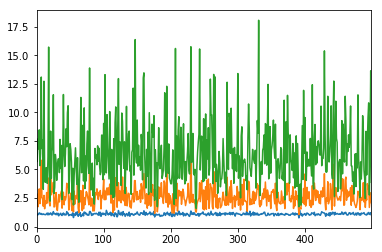